<a href="https://colab.research.google.com/github/agustin-sarasua/aws-serverless-api/blob/master/workshop_categorizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop Categorizacion 
Items categorization with NLP, Keras, Tensorflow, Pandas and Numpy

In [1]:
import requests
import time
import json
from collections import Counter
import random
from IPython.display import Image
# https://github.com/sepandhaghighi/pycm
!pip install pycm==1.8

import matplotlib.pyplot as plt
plt.figure(figsize=(12,9))

import pandas as pd # data preprocessing
import numpy as np # linear algebra

from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

    100% |████████████████████████████████| 51kB 2.0MB/s 
    100% |████████████████████████████████| 460kB 22.6MB/s 
    100% |████████████████████████████████| 215kB 28.8MB/s 
datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.2 which is incompatible.
coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 4.5.2 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1


<Figure size 864x648 with 0 Axes>

# Gather the Data

Download the zipped dataset of items from Google Drive (using the shareable link) and uncompress it.

In [2]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


download_file_from_google_drive('1kSPUjkf7gkB77UVTNnIW_cmGIjsa7GSh', 'arq.png')                
download_file_from_google_drive('1lD7fMlzNhx0AaPkoksrqJ4HEiTL_u5KM', 'vec.png')

download_file_from_google_drive('1Ql0az0GAC1_yHpHsAFvspKt1HZGMZOOa', 'cellphones.zip')
!unzip 'cellphones.zip'

Archive:  cellphones.zip
  inflating: cellphones.csv          


Here is the architecture of the Neural Network that we are going to train

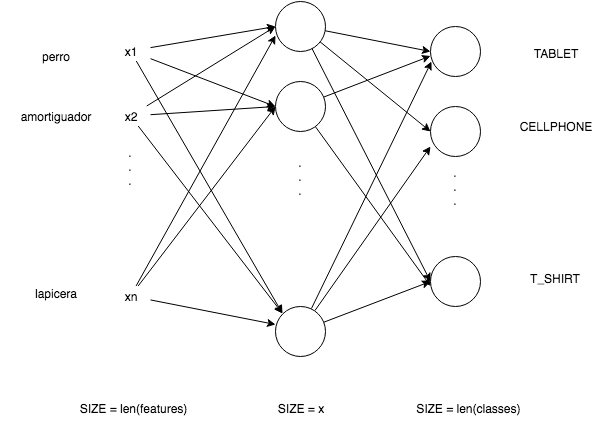

In [3]:
display(Image('arq.png'))

## Load the dataset using pandas
The dataset is a csv tab separated

See: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.htm

In [0]:
# 1 LoC aprox.
def read_csv(path='cellphones.csv'):
  dataset = pd.read_csv(path, sep='\t')
  return dataset

df = read_csv()

# Explore the Data

In [0]:
#df.describe()
#df.head()

Find how many classes we have in the dataset. 

This classes will be the output of the Neural Network

In [6]:
# 1 LoC aprox.
def get_num_classes(df):
  output_length = len(df.domain_id.unique())
  return output_length

num_classes = get_num_classes(df)
print("Output Lenght:", num_classes)
print("# Training examples:", len(df))

Output Lenght: 25
# Training examples: 62661


### Visualize the # of items per class

Bar plot the number of items per class.
1 - before ploting sort de values by counts.

See: 
Pandas Groupby https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

Pandas Count https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.count.html

Pandas Sort Values http://pandas.pydata.org/pandas-docs/version/0.19/generated/pandas.DataFrame.sort_values.html#pandas.DataFrame.sort_values

Pandas plot bar https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html



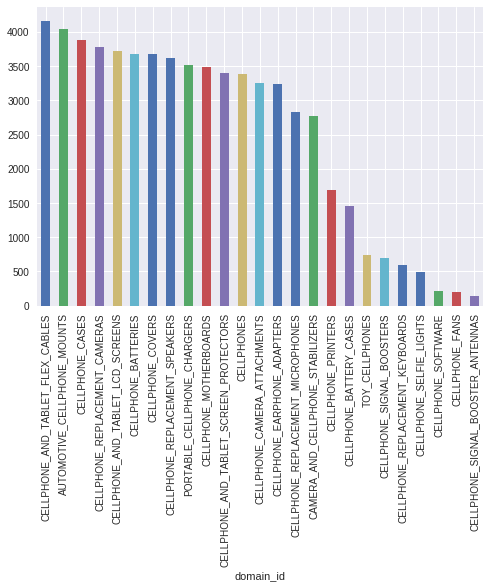

In [7]:
# From 1 to 4 LoC aprox. 
def plot_items_per_class(df):
  (df.groupby('domain_id')
           .count()
           .sort_values('title', ascending=False)['title']
           .rename(columns={"title":"counts"})).plot.bar(y='counts')

plot_items_per_class(df)  

### Visualize the class distribution

Plot the histogram - A histogram is a representation of the distribution of data

See: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.hist.html

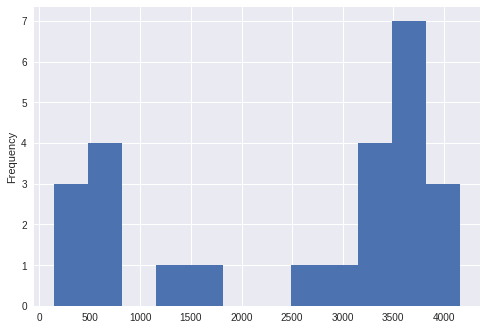

In [8]:
# From 1 to 4 LoC aprox. 
# Almost identical to previos solution
def plot_distribution(df):
  (df.groupby('domain_id')
           .count()
           .sort_values('title', ascending=False)['title']
           .rename(columns={"title":"counts"})).plot.hist(bins=12)

plot_distribution(df)  

# Prepare the data for training
Here is an image showing what we are to do with the data


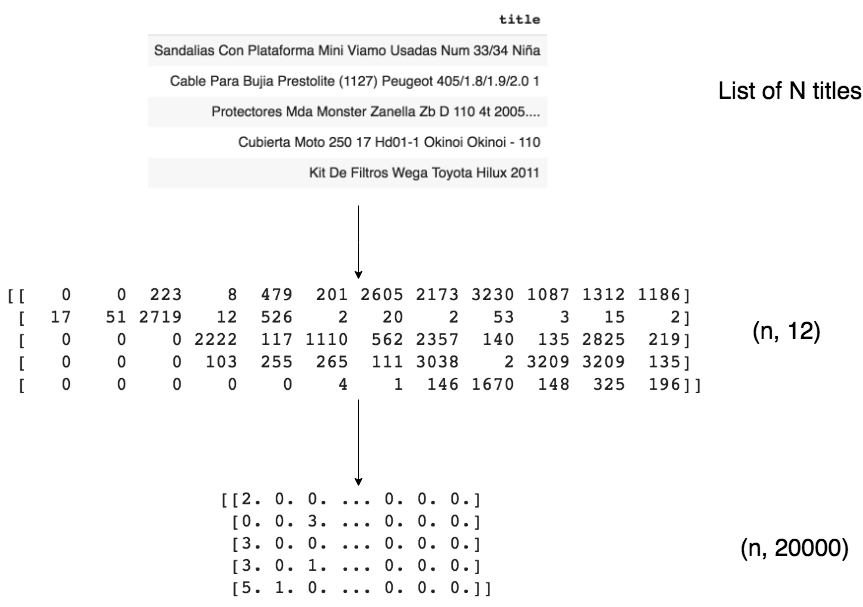

In [9]:
display(Image('vec.png'))

## Tokenization and Vectorization

Tokenization: Divide the texts into words or smaller sub-texts (tokens). This determines the “vocabulary” of the dataset.

Vectorization: Define a good numerical measure to characterize these texts.

Steps:
1. Fit a Keras Tokenizer using the text corpus (all the titles in the dataset)
2. Build a dictionary of indexes -> tokens
3. Create a function that parse the text to a sequence of decimals representing each token (step 2 in the image presented)
4. Vectorize the text using different representations or techniques (tfidf, bow, binary, etc)
5. Vectorize the labels (outputs of the NN)
6. Build a dictionary of indexes -> labels


### Fit a Keras Tokenizer

**From** https://keras.io/preprocessing/text/:

This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

In [0]:
def fit_keras_tokenizer(corpus, num_features=5000):
  tokenizer = text.Tokenizer(num_words=num_features, lower=True, split=' ')
  tokenizer.fit_on_texts(corpus)
  return tokenizer

In [11]:

tic = time.time()
num_features=5000

tokenizer = fit_keras_tokenizer(df['title'].values, num_features)

toc = time.time()    
print("Time to fit tokenizer: " + str(1000*(toc-tic)) + " ms")


Time to fit tokenizer: 1305.2904605865479 ms


### Build dictionary of index -> token

It shoud return a dictionary with the following format: 

{..., 1: "con", 2: "tablet", ...}

Note: use tokenizer.word_index

In [12]:
def build_idx_to_token(tokenizer):
  return {idx:tkn for tkn, idx in tokenizer.word_index.items()}

idx_to_token = build_idx_to_token(tokenizer)
print(idx_to_token)

{1: 'samsung', 2: 'para', 3: 'iphone', 4: 'de', 5: 'original', 6: 'celular', 7: 'funda', 8: 'galaxy', 9: 'plus', 10: 'lg', 11: 'cargador', 12: 'flex', 13: 'camara', 14: 'caso', 15: 'moto', 16: 'soporte', 17: 'placa', 18: 'vidrio', 19: '7', 20: 'con', 21: 'bateria', 22: 'motorola', 23: '6', 24: '3', 25: '5', 26: '2', 27: 'pantalla', 28: 'templado', 29: 'y', 30: 'sony', 31: 'x', 32: '8', 33: 'a', 34: 'microfono', 35: 'power', 36: 'trasera', 37: 'repuesto', 38: 'j7', 39: 'modulo', 40: 'auricular', 41: 'mini', 42: 'auto', 43: 'parlante', 44: 'portatil', 45: 'carga', 46: '4', 47: 'lente', 48: 'adaptador', 49: 'huawei', 50: 'en', 51: '6s', 52: 'note', 53: 'universal', 54: 'display', 55: 'altavoz', 56: 'nokia', 57: 'batería', 58: 'impresora', 59: 'libre', 60: 'cable', 61: 'film', 62: 'prime', 63: 'xperia', 64: '1', 65: 'glass', 66: 'colocacion', 67: 'usb', 68: 'carcasa', 69: 'frontal', 70: '2016', 71: 'protector', 72: 's8', 73: 'lcd', 74: 'bank', 75: 'touch', 76: 'teléfono', 77: 'cámara', 78:

### Parse titles to sequence of indexes
This function returns a sequence of indices representing the text

See https://keras.io/preprocessing/sequence/:

sequence.pad_sequences

use: tokenizer.texts_to_sequences(text)

In [0]:
'''
text: list of titles
max_seq_length: fixed length to the titles. 
  If the title has more than "max_seq_length" tokens => truncate it to max_seq_length
  If the title has less than "max_seq_length" tokens => complete at the begining with 0's 
'''
def parse_title_to_sequences(text, tokenizer, max_seq_length=12):
  # 1 - text to sequences
  text_sequences = tokenizer.texts_to_sequences(text)
  # 2 - Pad the sequences to a fix length, so every example has the same length
  text_sequences = sequence.pad_sequences(text_sequences, maxlen=max_seq_length)
  return text_sequences

Visualize what the vectorizer is actually doing

In [14]:
def print_vectorized_title(title, tokenizer, idx_to_token, num_features, mode='count'):
  print("------------------")
  print("Title:", title)
  print("------------------")
  print("Vectorizing title using %s mode" % mode)
  print("------------------")
  text_sequences = parse_title_to_sequences([title], tokenizer)

  vectorized_title = tokenizer.sequences_to_matrix(text_sequences.tolist(), mode=mode)
  assert vectorized_title.shape == (1, num_features)

  for tkn in set(text_sequences[0]):
    if tkn > 0:
      print(idx_to_token[tkn] ,vectorized_title[0][tkn])

title = "tablet samsung de tablet con para pantalla tablet"
print_vectorized_title(title, tokenizer, idx_to_token, num_features, 'binary')
print_vectorized_title(title, tokenizer, idx_to_token, num_features, 'count')
print_vectorized_title(title, tokenizer, idx_to_token, num_features, 'tfidf')


------------------
Title: tablet samsung de tablet con para pantalla tablet
------------------
Vectorizing title using binary mode
------------------
samsung 1.0
para 1.0
de 1.0
tablet 1.0
con 1.0
pantalla 1.0
------------------
Title: tablet samsung de tablet con para pantalla tablet
------------------
Vectorizing title using count mode
------------------
samsung 1.0
para 1.0
de 1.0
tablet 3.0
con 1.0
pantalla 1.0
------------------
Title: tablet samsung de tablet con para pantalla tablet
------------------
Vectorizing title using tfidf mode
------------------
samsung 1.6493240697185012
para 1.8794853335542474
de 2.0584739870189463
tablet 9.737773426323647
con 2.989402038865097
pantalla 3.1143238955252452


### Vectorize the text and labels

This function append a new column called "label" with an integer that uniquely identify that domain_id.
See https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html


In [0]:
def parse_labels_to_decimal(df):
  df['label'] = df['domain_id'].factorize()[0]
parse_labels_to_decimal(df)  

This builds the labels vocabulary. It shoud return a dictionary with the following format: 
{..., 1: "TABLETS", 2: "CELLPHONES", ...}

In [16]:
def build_idx_to_label(df):
  idx_to_label = {idx:domain_id for domain_id, idx in df.groupby(['domain_id', 'label']).groups.keys()}
  return idx_to_label

idx_to_label = build_idx_to_label(df)
# Check that everything is consistent
assert df[df['label']==3].reset_index().iloc[0]['domain_id'] == idx_to_label[3]
print(idx_to_label)

{16: 'AUTOMOTIVE_CELLPHONE_MOUNTS', 7: 'CAMERA_AND_CELLPHONE_STABILIZERS', 14: 'CELLPHONES', 0: 'CELLPHONE_AND_TABLET_FLEX_CABLES', 18: 'CELLPHONE_AND_TABLET_LCD_SCREENS', 10: 'CELLPHONE_AND_TABLET_SCREEN_PROTECTORS', 11: 'CELLPHONE_BATTERIES', 15: 'CELLPHONE_BATTERY_CASES', 5: 'CELLPHONE_CAMERA_ATTACHMENTS', 8: 'CELLPHONE_CASES', 17: 'CELLPHONE_COVERS', 12: 'CELLPHONE_EARPHONE_ADAPTERS', 24: 'CELLPHONE_FANS', 9: 'CELLPHONE_MOTHERBOARDS', 1: 'CELLPHONE_PRINTERS', 13: 'CELLPHONE_REPLACEMENT_CAMERAS', 22: 'CELLPHONE_REPLACEMENT_KEYBOARDS', 4: 'CELLPHONE_REPLACEMENT_MICROPHONES', 2: 'CELLPHONE_REPLACEMENT_SPEAKERS', 3: 'CELLPHONE_SELFIE_LIGHTS', 19: 'CELLPHONE_SIGNAL_BOOSTERS', 20: 'CELLPHONE_SIGNAL_BOOSTER_ANTENNAS', 23: 'CELLPHONE_SOFTWARE', 6: 'PORTABLE_CELLPHONE_CHARGERS', 21: 'TOY_CELLPHONES'}


We will be using categorical_crossentropy loss function (softmax), for this reason, we need to use one_hot encoding for our labels.

The representation should look like: [0, 0, ..., 1, 0] sparse vector with a "1" in the position of the target label.
  
 See https://keras.io/utils/ (to_categorial function)

In [0]:
from tensorflow.python.keras.utils import to_categorical

# 1 LoC aprox
def vectorize_labels(data, num_labels):
  # Convert labels to categorical one-hot encoding
  one_hot_labels = to_categorical(data, num_labels)
  return one_hot_labels

labels = vectorize_labels(df['label'].values, len(set(df['label'].values)))
# Run some Checks 
assert df.iloc[10]['domain_id'] == idx_to_label[df.iloc[10]['label']]
assert labels.shape[1] == num_classes

## Split the dataset

We will use 80% for training and 20% for validation

See: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [18]:
from sklearn.model_selection import train_test_split

def split_and_shuffle_dataset(df, val_size=0.2):
  # Random shuffle the dataset rows
  df = df.sample(frac=1).reset_index(drop=True)
  df_train, df_val = train_test_split(df, test_size=val_size)
  return df_train.reset_index(drop=True), df_val.reset_index(drop=True)

df_train, df_val = split_and_shuffle_dataset(df)
print(df_train.shape)
print(df_val.shape)

(50128, 5)
(12533, 5)


Vectorize the datasets 

In [0]:
def vectorize_the_datasets(df, df_train, df_val, tokenizer, mode='tfidf'):
  
  x_train_seq = parse_title_to_sequences(df_train['title'].values, tokenizer)
  x_train_vec = tokenizer.sequences_to_matrix(x_train_seq.tolist(), mode=mode)
  y_train_vec = vectorize_labels(df_train['label'].values, len(df.domain_id.unique()))

  x_val_seq = parse_title_to_sequences(df_val['title'].values, tokenizer)
  x_val_vec = tokenizer.sequences_to_matrix(x_val_seq.tolist(), mode=mode)
  y_val_vec = vectorize_labels(df_val['label'].values, len(df.domain_id.unique()))
  
  return x_train_vec, y_train_vec, x_val_vec, y_val_vec

x_train, y_train, x_val, y_val = vectorize_the_datasets(df, df_train, df_val, tokenizer, 'tfidf')  

# Run some checks
index = 45
assert y_train[index][df_train.iloc[index]['label']] == 1.
assert y_val[index][df_val.iloc[index]['label']] == 1.

# Build the model
We will first create a model using Keras Sequential API

Learn More: https://keras.io/getting-started/sequential-model-guide/

In [20]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import RMSprop, Adam

def build_model(num_features, num_classes):
  model = Sequential([
      Dense(512, input_shape=(num_features,), activation='relu'),
      Dense(num_classes, activation='softmax'),
  ])

  # For a multi-class classification problem
  model.compile(optimizer=Adam(lr=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

model = build_model(x_train.shape[1], y_train.shape[1])

Instructions for updating:
Colocations handled automatically by placer.


### Visualizing the Neural Network

In [21]:
!apt install graphviz;
!pip install pydot pydot-ng;

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2560512   
_________________________________________________________________
dense_1 (Dense)              (None, 25)                12825     
Total params: 2,573,337
Trainable params: 2,573,337
Non-trainable params: 0
_________________________________________________________________
None


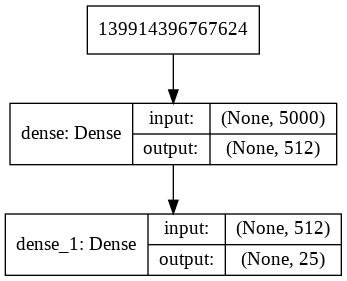

In [22]:
from keras.utils import plot_model

# Model summary
print(model.summary())

# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
display(Image('model.png'))

# Train the model
It is time to train the model

See: https://keras.io/models/model/ (fit function)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

def train_model(x_train, y_train, x_val, y_val):
  # Create callback for early stopping on validation loss. If the loss does
  # not decrease in two consecutive tries, stop training.
  callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

  # Train and validate model.
  history = model.fit(
      x_train,
      y_train,
      callbacks=callbacks,
      epochs=20,
      validation_data=(x_val, y_val),
      verbose=1,  # Logs once per epoch.
      batch_size=128)
  return history

history = train_model(x_train, y_train, x_val, y_val)

Train on 50128 samples, validate on 12533 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
50128/50128 [==============================] - 26s 511us/sample - loss: 1.4819 - acc: 0.7392 - val_loss: 0.5985 - val_acc: 0.8849
Epoch 2/20
50128/50128 [==============================] - 25s 504us/sample - loss: 0.4140 - acc: 0.9123 - val_loss: 0.3789 - val_acc: 0.9133
Epoch 3/20
50128/50128 [==============================] - 25s 508us/sample - loss: 0.2794 - acc: 0.9327 - val_loss: 0.3306 - val_acc: 0.9165
Epoch 4/20
50128/50128 [==============================] - 25s 506us/sample - loss: 0.2221 - acc: 0.9446 - val_loss: 0.3113 - val_acc: 0.9189
Epoch 5/20
50128/50128 [==============================] - 26s 515us/sample - loss: 0.1864 - acc: 0.9522 - val_loss: 0.3028 - val_acc: 0.9193
Epoch 6/20
50128/50128 [==============================] - 25s 502us/sample - loss: 0.1609 - acc: 0.9591 - val_loss: 0.3011 - val_acc: 0.9193
Epoch 7/20
50128/50128 [==============================] 

### Visualize the learning curves

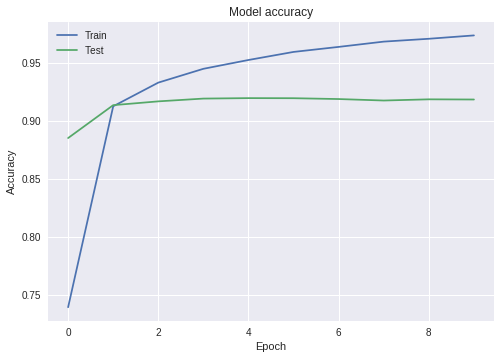

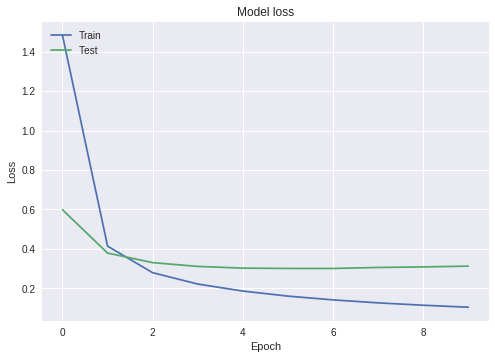

In [24]:
import matplotlib.pyplot as plt

def visualize_training_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

visualize_training_history(history)  

## Evaluate the model and visualize the Confusion Matrix

Write a function that takes any datasets (train or validation or any other), makes a prediction and return the decimal representation of the label

See: model.predict function https://keras.io/models/model/

See: np.argmax function https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html


In [0]:
# 2 LoC aprox.
def evaluate_model(x_data, model):
  y_pred = model.predict(x_val)
  y_pred = np.argmax(y_pred, axis=1)
  return y_pred

y_pred = evaluate_model(x_val, model)
y_act = np.argmax(y_val, axis=1)

### Visualize the errors and metrics

In [33]:
# From https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
from sklearn.metrics import f1_score
from pycm import *

cm = ConfusionMatrix(actual_vector=y_act, predict_vector=y_pred)
cm.save_html("cm_html")
#cm.print_matrix()
#cm.print_normalized_matrix()
#cm.print_matrix(one_vs_all=True, class_name=2)

print("Global F1-Score:" , f1_score(y_act, y_pred, average='micro'))

Global F1-Score: 0.9181361206415064


In [120]:
def print_errors(df_val, y_act, y_pred, idx_to_label, class_label=None, pred_label=None):
  for idx, row in df_val.iterrows():
    if class_label is not None and pred_label is not None:
      if y_act[idx] != y_pred[idx] and row['label']==class_label and y_pred[idx] == pred_label:
        print(row['item_id'], row['title'], 'Truth:', row['domain_id'], 'Prediction:',idx_to_label[y_pred[idx]])
    else:
      if y_act[idx] != y_pred[idx]:
        print(row['item_id'], row['title'], 'Truth:', row['domain_id'], 'Prediction:',idx_to_label[y_pred[idx]])

print_errors(df_val, y_act, y_pred, idx_to_label, 17, 8)        

MLA767919630 Wollony Iphone Max X Caso , Ultra Delgado Iphone Xs Max Blin Truth: CELLPHONE_COVERS Prediction: CELLPHONE_CASES
MLA769751559 Caso Iphone 6 / 6s, Firefish [ Característica Pata De Cabra Truth: CELLPHONE_COVERS Prediction: CELLPHONE_CASES
MLA769319039 Para Celular Estuche Galaxy Plastico Pa U1vt Truth: CELLPHONE_COVERS Prediction: CELLPHONE_CASES
MLA769082094 Iphone X Max Caso , Iphone X Max Billetera Caso , Iphone X M Truth: CELLPHONE_COVERS Prediction: CELLPHONE_CASES
MLA769072700 Para Celular Galaxy S6 Estuche Blando Sams Ffdt Truth: CELLPHONE_COVERS Prediction: CELLPHONE_CASES
MLA718974067 Samsung Galaxy Note8 Estuche, Ornarto [serie Basic] Thin Fit Truth: CELLPHONE_COVERS Prediction: CELLPHONE_CASES
MLA764482014 Prima Textura Pu Negro Cuero Cinturón Cadera Pistolera [cel Truth: CELLPHONE_COVERS Prediction: CELLPHONE_CASES
MLA769065774 Lg G5 Caso Prima Cuero Pu Capirotazo Billetera Caso Con La V Truth: CELLPHONE_COVERS Prediction: CELLPHONE_CASES
MLA769089978 S8 Caso Ga

In [28]:
print("Y_act", y_act[:10])
print("Y_pred",y_pred[:10])
print("Title:", df_val.iloc[0]['title'])
assert df_val.iloc[1]['domain_id'] == idx_to_label[y_pred[1]]


Y_act [19  9  8  8 16 10 11  7 14  6]
Y_pred [19  9  8 16 16 10 11  7 14  6]
Title: Countryman H6ow6bet  H6 Omnidireccional Inhalámbr- A Pedido!
